In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda ,Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import yolo_head,preprocess_true_boxes, yolo_loss
from model.yolo3 import yolo_body, tiny_yolo_body
from model.utils import get_random_data

from tqdm import tqdm
import time

In [3]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [4]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    '''data generator for fit_generator'''

    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            #if i==0:
            #    print("random")
            #    np.random.shuffle(annotation_lines)
            print(annotation_lines[i])
            image, box = get_random_data(annotation_lines[i], input_shape, random=False)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
       # print(image_data.shape)
        m_true = model.predict(image_data)
     

        yield image_data , box_data , y_true , m_true  #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model)

In [27]:
train_path = '2007_train.txt'
val_path = '2007_val.txt'
# test_path = '2007_test.txt'
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)

input_shape = (416,416) # multiple of 32, hw

with open(train_path) as f:
    train_lines = f.readlines()

with open(val_path) as f:
    val_lines = f.readlines()

# with open(test_path) as f:
#     test_lines = f.readlines()

num_anchors = len(anchors)
image_input = Input(shape=(416, 416, 3))
model = yolo_body(image_input, num_anchors//3, num_classes)
model.load_weights("model_data/trained_weights_final.h5")

#yolo3 = Reshape((13, 13, 3, 25))(model.layers[-3].output)
#yolo2 = Reshape((26, 26, 3, 25))(model.layers[-2].output)
#yolo1 = Reshape((52, 52, 3, 25))(model.layers[-1].output)


#model = Model( inputs= model.input , outputs=[yolo3,yolo2,yolo1] )

batch_size = 1


In [28]:
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

In [29]:
image = {}
box = {}
train_logits = {}
model_logits = {}

datagen = data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes,model)

In [30]:
img,box_data,flogits,mlogits = next(datagen)

D:\python\YOLO-Collection\yolov3-keras/VOCdevkit/VOC2007/JPEGImages/000012.jpg 156,97,351,270,6



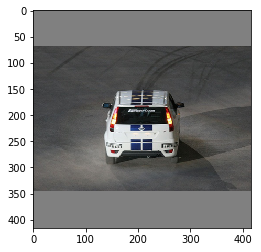

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(img[0])
plt.show()

In [26]:
flogits[0].shape

(2, 13, 13, 3, 25)

In [12]:
box_data

array([[[129., 149., 292., 293.,   6.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]],

       [[160., 103., 241., 222.,  14.],
        [ 78., 117., 349., 341.,  12.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]

In [24]:
arrpl = flogits[0]
arrpl[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxl = np.where(arrpl[:,:,:,:,4] > 0 )
boxl

(array([0, 1], dtype=int64),
 array([6, 7], dtype=int64),
 array([6, 6], dtype=int64),
 array([1, 1], dtype=int64))

In [14]:
box = boxl
arrp= arrpl
for i in range(len(box[0])):
    s = np.array(box)
    #print( i*5 )
    stp = i
   
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

(0,6,6,1)
[0.5048077  0.53125    0.39182693 0.34615386 1.        ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 = car
-------------------------------------------------------
(1,7,6,1)
[0.5120192  0.5504808  0.6514423  0.53846157 1.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
12 = horse
-------------------------------------------------------


In [15]:
object_mask = flogits[0][..., 4:5]
object_mask.shape

(2, 13, 13, 3, 1)

In [16]:
def yolo_heads(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs



In [17]:
mlogits[0].shape

(2, 13, 13, 75)

In [18]:
def box_iou(b1, b2):
    '''Return iou tensor

    Parameters
    ----------
    b1: tensor, shape=(i1,...,iN, 4), xywh
    b2: tensor, shape=(j, 4), xywh

    Returns
    -------
    iou: tensor, shape=(i1,...,iN, j)

    '''

    # Expand dim to apply broadcasting.
    b1 = K.expand_dims(b1, -2)
    b1_xy = b1[..., :2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh/2.
    b1_mins = b1_xy - b1_wh_half
    b1_maxes = b1_xy + b1_wh_half

    # Expand dim to apply broadcasting.
    b2 = K.expand_dims(b2, 0)
    b2_xy = b2[..., :2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh/2.
    b2_mins = b2_xy - b2_wh_half
    b2_maxes = b2_xy + b2_wh_half

    intersect_mins = K.maximum(b1_mins, b2_mins)
    intersect_maxes = K.minimum(b1_maxes, b2_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b1_area = b1_wh[..., 0] * b1_wh[..., 1]
    b2_area = b2_wh[..., 0] * b2_wh[..., 1]
    iou = intersect_area / (b1_area + b2_area - intersect_area)

    return iou

In [19]:
import tensorflow as tf
with tf.variable_scope("foo", reuse=tf.AUTO_REUSE):
    outputm = tf.get_variable("tf_var_initialized_from_np", initializer= mlogits[0] )


In [20]:
num_layers = len(anchors)//3 # default setting
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

grid, raw_pred, pred_xy, pred_wh = yolo_heads( outputm ,anchors[anchor_mask[0]], num_classes, input_shape, calc_loss=True)
pred_box = K.concatenate([pred_xy, pred_wh])
    

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print(pred_box.eval().shape)

(2, 13, 13, 3, 4)


In [21]:
object_mask_bool = K.cast(object_mask, 'bool')
true_box = tf.boolean_mask(flogits[0][0,...,0:4], object_mask_bool[0,...,0])

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print(object_mask_bool.eval().shape)
    print(true_box.eval())
    

(2, 13, 13, 3, 1)
[[0.5048077  0.53125    0.39182693 0.34615386]]


In [23]:
iou = box_iou(pred_box[0], true_box)
best_iou = K.max(iou, axis=-1)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    ignore_thresh=.5
    ck = best_iou.eval() > ignore_thresh
    
    print( iou.eval().shape )
    print( best_iou.eval().shape )
    
    arrpl = best_iou.eval()
    boxl = np.where(arrpl[:,:,:] > 0 )
    print( boxl )
    
    #print( ck.shape )
    #print( sum( ck ) )
    #dad = sum(ck)
    #print(dad.shape)
    
    print( iou.eval() )
    print( best_iou.eval() )
    

(13, 13, 3, 1)
(13, 13, 3)
(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  

   [2.01954059e-02]]]]
[[[0.00000000e+00 0.00000000e+00 1.27094444e-02]
  [0.00000000e+00 1.42765697e-04 1.87660530e-02]
  [0.00000000e+00 5.12992591e-03 0.00000000e+00]
  [0.00000000e+00 8.28528311e-03 8.68663471e-03]
  [0.00000000e+00 1.05806822e-02 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 2.39874870e-02]
  [0.00000000e+00 0.00000000e+00 1.13251749e-02]
  [0.00000000e+00 0.00000000e+00 3.79181430e-02]
  [0.00000000e+00 0.00000000e+00 1.70691628e-02]
  [0.00000000e+00 5.35343215e-03 7.56224478e-03]]

 [[0.00000000e+00 0.00000000e+00 2.18618829e-02]
  [0.00000000e+00 0.00000000e+00 2.47022491e-02]
  [0.00000000e+00 4.44688695e-03 3.01234629e-02]
  [6.07145578e-03 2.58056866e-03 4.27510701e-02]
  [4.25947756e-02 1.63547210e-02 1.65980943e-02]
  [2.98398342e-02 0.00000000e+00 3.25327367e-02]
  [2.03124583e-02 0.00000000e+00 1.64598990e

  [0.00000000e+00 6.45943079e-03 2.01954059e-02]]]


In [ ]:
arr.shape